In [ ]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, Dense, Dropout, BatchNormalization, AveragePooling2D, Concatenate, Input, Flatten
from tensorflow.keras.models import Model
import os
import matplotlib.pyplot as plt
import scipy.interpolate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import uuid
import librosa
from glob import glob
from pathlib import Path
from IPython.display import Audio, display


In [ ]:
import patoolib
import os

# Путь к ZIP-файлу
rar_path = '/home/jupyter/datasphere/project/groove-v1.0.0.rar'  # Укажите ваш путь
# Папка, куда распаковать
extract_path = '/home/jupyter/datasphere/project/data_groove'  # Укажите папку

# Создаем папку для распаковки, если она не существует
os.makedirs(extract_path, exist_ok=True)

# Распаковываем архив
patoolib.extract_archive(rar_path, outdir=extract_path)


# Проверяем содержимое распакованной папки
print(os.listdir(extract_path))

In [ ]:
#%pip install patool

# Сбор данных для обучения
Сами итоговые датасеты загружены в репозиторий уже поделенные на test и train.

## 1 датасет

In [36]:

genres_path = '/home/jupyter/datasphere/project/data/genres_original'
audio_files = []
labels = []

# Проходим по жанрам
for genre in os.listdir(genres_path):
    genre_path = os.path.join(genres_path, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith('.wav'):
                audio_files.append(os.path.join(genre_path, file))
                labels.append(genre)

# Создаём DataFrame
df_gtzan = pd.DataFrame({'file_path': audio_files, 'label': labels})
print(df_gtzan.head())

                                           file_path  label
0  /home/jupyter/datasphere/project/data/genres_o...  blues
1  /home/jupyter/datasphere/project/data/genres_o...  blues
2  /home/jupyter/datasphere/project/data/genres_o...  blues
3  /home/jupyter/datasphere/project/data/genres_o...  blues
4  /home/jupyter/datasphere/project/data/genres_o...  blues


In [37]:
random_row = df_gtzan.sample(n=1)
random_audio_path = random_row['file_path'].iloc[0]
random_label = random_row['label'].iloc[0]
print(f"Случайная дорожка: {random_audio_path}, Жанр: {random_label}")

# Воспроизводим
audio = Audio(random_audio_path)
display(audio)

Случайная дорожка: /home/jupyter/datasphere/project/data/genres_original/jazz/jazz.00010.wav, Жанр: jazz


In [40]:
features_30 = pd.read_csv('/home/jupyter/datasphere/project/data/features_30_sec.csv')
df_gtzan['filename'] = df_gtzan['file_path'].apply(lambda x: os.path.basename(x))
df_gtzan_with_bpm = df_gtzan.merge(features_30[['filename', 'tempo']], on='filename', how='left')
df_gtzan_with_bpm = df_gtzan_with_bpm.rename(columns={'tempo': 'bpm'})

print("Количество пропущенных BPM:", df_gtzan_with_bpm['bpm'].isna().sum())
print("Первые строки датасета:")
print(df_gtzan_with_bpm.head())
print("\nСтатистика по BPM:")
print(df_gtzan_with_bpm['bpm'].describe())
print("\nСредний BPM по жанрам:")
print(df_gtzan_with_bpm.groupby('label')['bpm'].mean())

Количество пропущенных BPM: 0
Первые строки датасета:
                                           file_path  ...         bpm
0  /home/jupyter/datasphere/project/data/genres_o...  ...  123.046875
1  /home/jupyter/datasphere/project/data/genres_o...  ...   67.999589
2  /home/jupyter/datasphere/project/data/genres_o...  ...  161.499023
3  /home/jupyter/datasphere/project/data/genres_o...  ...   63.024009
4  /home/jupyter/datasphere/project/data/genres_o...  ...  135.999178

[5 rows x 4 columns]

Статистика по BPM:
count    1000.000000
mean      119.505363
std        28.264176
min        54.978391
25%        99.384014
50%       117.453835
75%       135.999178
max       234.907670
Name: bpm, dtype: float64

Средний BPM по жанрам:
label
blues        120.742207
classical    127.920952
country      110.858840
disco        120.341798
hiphop       112.945646
jazz         115.068143
metal        124.873912
pop          112.759957
reggae       129.279738
rock         120.262441
Name: bpm, dtype: fl

## 2 датасет

In [41]:
echonest = pd.read_csv(os.path.join(metadata_dir, 'echonest.csv'), index_col=0, header=[0, 1, 2])

In [18]:
genres_path = '/home/jupyter/datasphere/project/medi_fma/fma_medium'
audio_files = []
labels = []

for genre in os.listdir(genres_path):
    genre_path = os.path.join(genres_path, genre)
    if os.path.isdir(genre_path):
        for file in os.listdir(genre_path):
            if file.endswith('.mp3'):
                audio_files.append(os.path.join(genre_path, file))
                labels.append(file)

df_FMA = pd.DataFrame({'file_path': audio_files, 'label': labels})

def filename_to_id(filename):
    base_name = os.path.splitext(filename)[0]
    return int(base_name)

df_FMA['track_id'] = df_FMA['label'].apply(filename_to_id)
print(df_FMA.head())

                                           file_path       label  track_id
0  /home/jupyter/datasphere/project/medi_fma/fma_...  000002.mp3         2
1  /home/jupyter/datasphere/project/medi_fma/fma_...  000003.mp3         3
2  /home/jupyter/datasphere/project/medi_fma/fma_...  000005.mp3         5
3  /home/jupyter/datasphere/project/medi_fma/fma_...  000010.mp3        10
4  /home/jupyter/datasphere/project/medi_fma/fma_...  000134.mp3       134


In [19]:
random_row = df_FMA.sample(n=1)
random_audio_path = random_row['file_path'].iloc[0]
random_label = random_row['label'].iloc[0]
print(f"Случайная дорожка: {random_audio_path}, Название: {random_label}")

audio = Audio(random_audio_path)
display(audio)

Случайная дорожка: /home/jupyter/datasphere/project/medi_fma/fma_medium/116/116909.mp3, Название: 116909.mp3


In [42]:
echonest = pd.read_csv(os.path.join(metadata_dir, 'echonest.csv'), index_col=0, header=[0, 1, 2])
bpm_data = echonest['echonest', 'audio_features']['tempo']

In [43]:
df_FMA_with_bpm = df_FMA.merge(bpm_data, on='track_id', how='left')
df_FMA_with_bpm = df_FMA_with_bpm.rename(columns={'tempo': 'bpm'})

print("Количество пропущенных BPM:", df_FMA_with_bpm['bpm'].isna().sum())
print("Первые строки датасета:")
print(df_FMA_with_bpm.head())
print("\nСтатистика по BPM:")
print(df_FMA_with_bpm['bpm'].describe())
print("\nСредний BPM по жанрам:")
print(df_FMA_with_bpm.groupby('label')['bpm'].mean())
df_FMA_with_bpm = df_FMA_with_bpm.dropna(subset = ['bpm'])

Количество пропущенных BPM: 19719
Первые строки датасета:
                                           file_path  ...      bpm
0  /home/jupyter/datasphere/project/medi_fma/fma_...  ...  165.922
1  /home/jupyter/datasphere/project/medi_fma/fma_...  ...  126.957
2  /home/jupyter/datasphere/project/medi_fma/fma_...  ...  100.260
3  /home/jupyter/datasphere/project/medi_fma/fma_...  ...  111.562
4  /home/jupyter/datasphere/project/medi_fma/fma_...  ...  114.290

[5 rows x 4 columns]

Статистика по BPM:
count    5281.000000
mean      123.441879
std        35.159151
min        12.753000
25%        95.982000
50%       120.169000
75%       146.641000
max       250.059000
Name: bpm, dtype: float64

Средний BPM по жанрам:
label
000002.mp3    165.922
000003.mp3    126.957
000005.mp3    100.260
000010.mp3    111.562
000134.mp3    114.290
               ...   
155297.mp3        NaN
155298.mp3        NaN
155306.mp3        NaN
155307.mp3        NaN
155314.mp3        NaN
Name: bpm, Length: 25000, dtype:

## 3 датасет

In [24]:
genres_path = '/home/jupyter/datasphere/project/data_groove/groove-v1.0.0/groove'
audio_files = []
labels = []

wav_files = glob(os.path.join(genres_path, '**/*.wav'), recursive=True)
df_groove = pd.DataFrame({'file_path': wav_files})
df_groove['filename'] = df_groove['file_path'].apply(os.path.basename)

In [26]:
random_row = df_groove.sample(n=1)
random_audio_path = random_row['file_path'].iloc[0]
random_label = random_row['filename'].iloc[0]
print(f"Случайная дорожка: {random_audio_path}, Название: {random_label}")

# Воспроизводим
audio = Audio(random_audio_path)
display(audio)

Случайная дорожка: /home/jupyter/datasphere/project/data_groove/groove-v1.0.0/groove/drummer1/112_funk_95_fill_4-4.wav, Название: 112_funk_95_fill_4-4.wav


In [44]:
def get_filename_after_second_slash(path):
    parts = path.replace('\\', '/').split('/')
    return parts[2] if len(parts) > 2 else os.path.basename(path)

features_3 = pd.read_csv('/home/jupyter/datasphere/project/info_groove.csv')
features_3 = features_3.dropna()
features_3['filename'] = features_3['audio_filename'].apply(get_filename_after_second_slash)
df_groove_with_bpm = df_groove.merge(features_3, on='filename', how='left')[['file_path', 'bpm', 'filename']]

print("Количество пропущенных BPM:", df_groove_with_bpm['bpm'].isna().sum())
print("Первые строки датасета:")
print(df_groove_with_bpm.head())
print("\nСтатистика по BPM:")
print(df_groove_with_bpm['bpm'].describe())
print("\nСредний BPM по жанрам:")
print(df_groove_with_bpm.groupby('filename')['bpm'].mean())

Количество пропущенных BPM: 0
Первые строки датасета:
                                           file_path  ...                                   filename
0  /home/jupyter/datasphere/project/data_groove/g...  ...              100_funk-rock_92_fill_4-4.wav
1  /home/jupyter/datasphere/project/data_groove/g...  ...  100_neworleans-secondline_94_beat_4-4.wav
2  /home/jupyter/datasphere/project/data_groove/g...  ...           101_dance-disco_120_beat_4-4.wav
3  /home/jupyter/datasphere/project/data_groove/g...  ...              101_funk-rock_92_fill_4-4.wav
4  /home/jupyter/datasphere/project/data_groove/g...  ...              102_funk-rock_92_fill_4-4.wav

[5 rows x 3 columns]

Статистика по BPM:
count    1178.000000
mean      108.241935
std        23.230405
min        50.000000
25%        93.000000
50%       105.000000
75%       122.000000
max       290.000000
Name: bpm, dtype: float64

Средний BPM по жанрам:
filename
100_funk-rock_92_fill_4-4.wav                 92.0
100_hiphop_70_fill_4

## 4 датасет

Этот датасет ради эксперимента самостоятельно размечен через librosa. После его добавление метрика улучшилась.

In [1]:
audio_dir = '/home/jupyter/datasphere/project/ballroom_data'  
output_csv = '/home/jupyter/datasphere/project/ballroom_dataset.csv'  

BPM_RANGE = range(30, 286) 
audio_extensions = ['*.mp3', '*.wav'] 
audio_files = []
for ext in audio_extensions:
    audio_files.extend(glob(os.path.join(audio_dir, '**', ext), recursive=True))
print(f"Найдено аудиофайлов: {len(audio_files)}")
print(audio_files[:5])

df_ballroom = pd.DataFrame({'file_path': audio_files})
 df_lmd[~df_lmd['file_path'].apply(os.path.exists)]


Найдено аудиофайлов: 698
['/home/jupyter/datasphere/project/ballroom_data/BallroomData/Jive/Media-103515.wav', '/home/jupyter/datasphere/project/ballroom_data/BallroomData/Jive/Media-103516.wav', '/home/jupyter/datasphere/project/ballroom_data/BallroomData/Jive/Media-103517.wav', '/home/jupyter/datasphere/project/ballroom_data/BallroomData/Jive/Media-103611.wav', '/home/jupyter/datasphere/project/ballroom_data/BallroomData/Jive/Media-103612.wav']


,file_path
0,/home/jupyter/datasphere/project/ballroom_data...
1,/home/jupyter/datasphere/project/ballroom_data...
2,/home/jupyter/datasphere/project/ballroom_data...
3,/home/jupyter/datasphere/project/ballroom_data...
4,/home/jupyter/datasphere/project/ballroom_data...
...,...
693,/home/jupyter/datasphere/project/ballroom_data...
694,/home/jupyter/datasphere/project/ballroom_data...
695,/home/jupyter/datasphere/project/ballroom_data...
696,/home/jupyter/datasphere/project/ballroom_data...


In [46]:
paths = df_ballroom['file_path']

bpms = []
for path in paths:
    y, sr = librosa.load(path) 
    tempo, _ = librosa.beat.beat_track(y=y, sr=sr) 
    bpms.append(tempo)
    

df_ballroom['bpm'] = bpms
#df_ballroom.to_csv('dataset_with_bpm.csv', index=False)

In [47]:
df_ballroom

,file_path,bpm,dataset
0,/home/jupyter/datasphere/project/ballroom_data...,80.749512,ballroom
1,/home/jupyter/datasphere/project/ballroom_data...,83.354335,ballroom
2,/home/jupyter/datasphere/project/ballroom_data...,89.102909,ballroom
3,/home/jupyter/datasphere/project/ballroom_data...,83.354335,ballroom
4,/home/jupyter/datasphere/project/ballroom_data...,172.265625,ballroom
...,...,...,...
693,/home/jupyter/datasphere/project/ballroom_data...,99.384014,ballroom
694,/home/jupyter/datasphere/project/ballroom_data...,99.384014,ballroom
695,/home/jupyter/datasphere/project/ballroom_data...,151.999081,ballroom
696,/home/jupyter/datasphere/project/ballroom_data...,151.999081,ballroom


# Построение модели

In [25]:
df_groove_with_bpm = df_groove_with_bpm[['file_path', 'bpm']][:1000]
df_FMA_with_bpm = df_FMA_with_bpm[['file_path', 'bpm']]
df_gtzan_with_bpm = df_gtzan_with_bpm[['file_path', 'bpm']]
df_ballroom = df_ballroom[['file_path', 'bpm']]

df_groove_with_bpm = df_groove_with_bpm[(df_groove_with_bpm['bpm'] >= 30) & (df_groove_with_bpm['bpm'] <= 300)]
df_FMA_with_bpm = df_FMA_with_bpm[(df_FMA_with_bpm['bpm'] >= 30) & (df_FMA_with_bpm['bpm'] <= 300)]
df_gtzan_with_bpm = df_gtzan_with_bpm[(df_gtzan_with_bpm['bpm'] >= 30) & (df_gtzan_with_bpm['bpm'] <= 300)]
df_ballroom = df_ballroom[(df_ballroom['bpm'] >= 30) & (df_ballroom['bpm'] <= 300)]

In [30]:
df_groove_with_bpm['dataset'] = 'groove'
df_FMA_with_bpm['dataset'] = 'FMA'
df_gtzan_with_bpm['dataset'] = 'gtzan'
df_ballroom['dataset'] = 'ballroom'

In [31]:
TRAIN_SIZE = 0.8
VAL_SIZE = 0.1
TEST_SIZE = 0.1
RANDOM_STATE = 42

def clean_dataframe(df, dataset_name):
   
    # Округление bpm и фильтрация по диапазону
    df['bpm'] = df['bpm'].round().astype(int)
    
    return df

#функция для объединения датасетов
def merge_datasets( df_fma_with_bpm, df_gtzan_with_bpm, df__groove_with_bpm, df_ballroom): #df_groove_with_bpm,
    df_groove_clean = clean_dataframe(df_groove_with_bpm, 'groove')
    df_fma_clean = clean_dataframe(df_fma_with_bpm, 'fma')
    df_gtzan_clean = clean_dataframe(df_gtzan_with_bpm, 'gtzan')
    df_ballroom_clean = clean_dataframe(df_ballroom, 'ballroom')
    df_combined = pd.concat([ df_fma_clean, df_gtzan_clean, df_groove_clean, df_ballroom_clean], ignore_index=True) #df_groove_clean,
    df_combined = df_combined.drop_duplicates(subset=['file_path'])
    
    return df_combined

def split_datasets(df_combined):
    #столбец для стратификации (dataset + диапазон bpm)
    df_combined['bpm_bin'] = pd.cut(
        df_combined['bpm'],
        bins=[30, 90, 120, 150, 180, 220, 286],
        labels=['30-90', '90-120', '120-150', '150-180', '180-220', '220-286']
    )
    df_combined['stratify_col'] = df_combined['dataset'] + '_' + df_combined['bpm_bin'].astype(str)
    stratify_counts = df_combined['stratify_col'].value_counts()
    print("\nРаспределение stratify_col:")
    print(stratify_counts)
    
    #фильтрация классов с менее чем 2 примерами
    valid_classes = stratify_counts[stratify_counts >= 2].index
    df_filtered = df_combined[df_combined['stratify_col'].isin(valid_classes)].copy()
    
    if len(df_filtered) < len(df_combined):
        print(f"\nВнимание: {len(df_combined) - len(df_filtered)} треков исключено из-за редких классов")
        if len(df_filtered) < 0.9 * len(df_combined):
            print("Слишком много данных исключено")
            #стратификация только по dataset
            train_val_df, test_df = train_test_split(
                df_combined,
                test_size=TEST_SIZE,
                stratify=df_combined['dataset'],
                random_state=RANDOM_STATE
            )
            relative_val_size = VAL_SIZE / (TRAIN_SIZE + VAL_SIZE)
            train_df, val_df = train_test_split(
                train_val_df,
                test_size=relative_val_size,
                stratify=train_val_df['dataset'],
                random_state=RANDOM_STATE
            )
        else:
            #стратификация по отфильтрованному stratify_col
            train_val_df, test_df = train_test_split(
                df_filtered,
                test_size=TEST_SIZE,
                stratify=df_filtered['stratify_col'],
                random_state=RANDOM_STATE
            )
            relative_val_size = VAL_SIZE / (TRAIN_SIZE + VAL_SIZE)
            train_df, val_df = train_test_split(
                train_val_df,
                test_size=relative_val_size,
                stratify=train_val_df['stratify_col'],
                random_state=RANDOM_STATE
            )
    else:
        #стратификация по stratify_col
        train_val_df, test_df = train_test_split(
            df_filtered,
            test_size=TEST_SIZE,
            stratify=df_filtered['stratify_col'],
            random_state=RANDOM_STATE
        )
        relative_val_size = VAL_SIZE / (TRAIN_SIZE + VAL_SIZE)
        train_df, val_df = train_test_split(
            train_val_df,
            test_size=relative_val_size,
            stratify=train_val_df['stratify_col'],
            random_state=RANDOM_STATE
        )
    
    for df in [train_df, val_df, test_df]:
        df.drop(columns=['bpm_bin', 'stratify_col'], inplace=True)
        
    return train_df, val_df, test_df

In [33]:
def main(df_FMA_with_bpm, df_gtzan_with_bpm, df_groove, df_ballroom): #df_groove_with_bpm,
    for df, name in [ (df_FMA_with_bpm, 'fma'), (df_gtzan_with_bpm, 'gtzan'), (df_groove_with_bpm, 'groove'), (df_ballroom, 'ballroom')]: #(df_groove_with_bpm, 'groove'),
        if not isinstance(df, pd.DataFrame):
            raise ValueError(f"Датасет {name} должен быть pandas DataFrame")
        if not all(col in df.columns for col in ['file_path', 'bpm']):
            raise ValueError(f"Датасет {name} должен содержать столбцы: file_path, bpm")

    df_combined = merge_datasets(df_FMA_with_bpm, df_gtzan_with_bpm, df_groove, df_ballroom) #(df_groove_with_bpm, 'groove'),
    print(f"Общий датафрейм: {len(df_combined)} треков")
    print("Распределение по датасетам:")
    print(df_combined['dataset'].value_counts())
    train_df, val_df, test_df = split_datasets(df_combined)
    
    print("\nРазмеры подвыборок:")
    print(f"Train: {len(train_df)} треков")
    print(f"Val: {len(val_df)} треков")
    print(f"Test: {len(test_df)} треков")
    
    print("\nРаспределение по датасетам в подвыборках:")

    for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
        print(f"\n{name}:")
        print(df['dataset'].value_counts())
    train_df.to_csv('train_dataset.csv', index=False)
    val_df.to_csv('val_dataset.csv', index=False)
    test_df.to_csv('test_dataset.csv', index=False)
    print("\nПодвыборки сохранены: train_dataset.csv, val_dataset.csv, test_dataset.csv")

main( df_FMA_with_bpm, df_gtzan_with_bpm, df_groove, df_ballroom) #df_groove_with_bpm,

Общий датафрейм: 8011 треков
Распределение по датасетам:
FMA         5281
groove      1032
gtzan       1000
ballroom     698
Name: dataset, dtype: int64

Распределение stratify_col:
FMA_90-120          1713
FMA_120-150         1466
FMA_30-90            944
FMA_150-180          833
groove_90-120        544
gtzan_90-120         420
gtzan_120-150        283
FMA_180-220          281
groove_120-150       281
ballroom_90-120      253
ballroom_120-150     203
groove_30-90         189
gtzan_150-180        131
gtzan_30-90          130
ballroom_30-90       119
ballroom_150-180     100
FMA_220-286           39
gtzan_180-220         35
ballroom_180-220      23
groove_150-180        11
groove_180-220         6
FMA_nan                5
groove_nan             1
gtzan_220-286          1
Name: stratify_col, dtype: int64

Внимание: 2 треков исключено из-за редких классов

Размеры подвыборок:
Train: 6407 треков
Val: 801 треков
Test: 801 треков

Распределение по датасетам в подвыборках:

Train:
FMA       

Размеры датасетов: Train=6407, Val=801, Test=801
Обработка обучающего набора...


[src/libmpg123/layer3.c:INT123_do_layer3():1771] error: part2_3_length (3264) too large for available bit count (3224)
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!
[src/libmpg123/layer3.c:INT123_do_layer3():1801] error: dequantization failed!


Пропущен файл /home/jupyter/datasphere/project/medi_fma/fma_medium/037/037014.mp3: adjusted_bpm=12 вне диапазона range(30, 286)
Пропущен файл /home/jupyter/datasphere/project/medi_fma/fma_medium/019/019353.mp3: adjusted_bpm=23 вне диапазона range(30, 286)
Пропущено файлов: 2
Обработка валидационного набора...


[src/libmpg123/layer3.c:INT123_do_layer3():1841] error: dequantization failed!


Пропущен файл /home/jupyter/datasphere/project/medi_fma/fma_medium/014/014921.mp3: adjusted_bpm=27 вне диапазона range(30, 286)
Пропущено файлов: 1
Обработка тестового набора...
Ошибка при обработке /home/jupyter/datasphere/project/data/genres_original/jazz/jazz.00054.wav: 


/tmp/ipykernel_3902/2951291017.py:76: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=SR, mono=True)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Пропущен файл /home/jupyter/datasphere/project/medi_fma/fma_medium/000/000718.mp3: adjusted_bpm=20 вне диапазона range(30, 286)
Пропущено файлов: 2
Размеры данных: X_train=(6405, 40, 256, 1), X_val=(3455, 40, 256, 1), X_test=(3538, 40, 256, 1)
Epoch 1/400


2025-05-20 14:33:17.683860: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_1/dropout_5/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


201/201 [==============================] - 27s 76ms/step - loss: 5.2605 - accuracy: 0.0116 - val_loss: 4.9428 - val_accuracy: 0.0124 - lr: 0.0010
Epoch 2/400
201/201 [==============================] - 14s 68ms/step - loss: 4.9524 - accuracy: 0.0203 - val_loss: 5.1227 - val_accuracy: 0.0087 - lr: 0.0010
Epoch 3/400
201/201 [==============================] - 14s 69ms/step - loss: 4.9146 - accuracy: 0.0203 - val_loss: 5.4945 - val_accuracy: 0.0084 - lr: 0.0010
Epoch 4/400
201/201 [==============================] - 14s 69ms/step - loss: 4.9026 - accuracy: 0.0206 - val_loss: 5.5184 - val_accuracy: 0.0046 - lr: 0.0010
Epoch 5/400
201/201 [==============================] - 14s 70ms/step - loss: 4.8874 - accuracy: 0.0226 - val_loss: 5.1314 - val_accuracy: 0.0226 - lr: 0.0010
Epoch 6/400
201/201 [==============================] - 14s 70ms/step - loss: 4.8759 - accuracy: 0.0215 - val_loss: 5.2956 - val_accuracy: 0.0336 - lr: 0.0010
Epoch 7/400
201/201 [==============================] - 14s 70ms/

/tmp/ipykernel_3902/2951291017.py:285: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


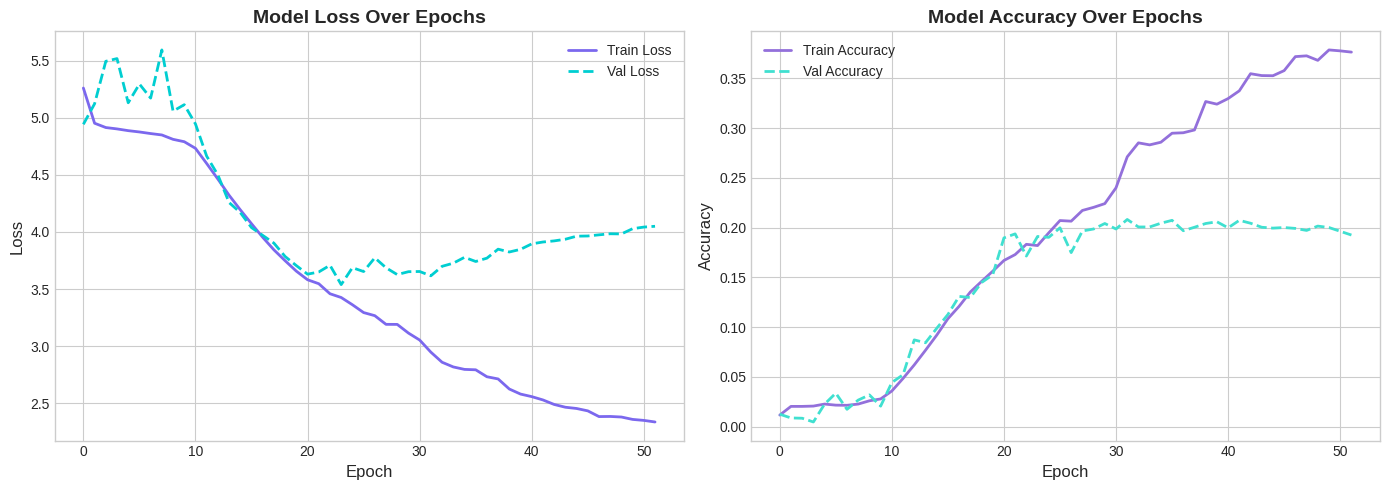

111/111 [==============================] - 2s 12ms/step
Результаты на тестовом наборе:
Accuracy0: 0.2292
Accuracy1: 0.5786
Accuracy2: 0.7027
1/1 [==============================] - 0s 29ms/step
File: /home/jupyter/datasphere/project/medi_fma/fma_medium/059/059667.mp3
Общий BPM: 74
Текущий BPM: [151, 76, 74, 74]


In [ ]:
SR = 11025 #частота дискретизации
N_FFT = 1024 #количество точек БПФ для преобразования Фурье
HOP_LENGTH = 512 #параметр определяющий временное рарешение спектограммы
N_MELS = 40 #количество полос mel-спектограммы
FMIN = 20
FMAX = 5000  #частотный диапазон
FRAME_LENGTH = 256   #длина окна спектограммы
BPM_RANGE = range(30, 286)  # 30-285 bpm, 256 классов
NUM_CLASSES = len(BPM_RANGE) 
TRAIN_SIZE = 0.75
VAL_SIZE = 0.1
TEST_SIZE = 0.15
RANDOM_STATE = 42
SCALE_FACTORS = np.arange(0.8, 1.21, 0.04)   #коэффициенты для увеличения растяжения во времени, значения взяты из статьи

def frequency_augmentation(mel_spec, max_gain_db=5): 
    #--------------------------------
    #Применяет случайные регулировки для отдельных 
    #частотных диапазонов Mel-спектограммы. 
    #Делает модель более устойчивой в стилях микширования
    #--------------------------------
    mel_spec = mel_spec.copy()
    num_bands = mel_spec.shape[0]
    for band in range(num_bands):
        if np.random.rand() < 0.3: 
            gain = np.random.uniform(-max_gain_db, max_gain_db)
            mel_spec[band, :] *= 10 ** (gain / 20)
    return mel_spec

def add_noise(y, snr_db=30):
    #------------------------
    #Добавляет случайный гауссовский шум в аудиосигнал
    #------------------------
    snr_db = np.random.uniform(10, 40)  
    signal_power = np.mean(y ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), len(y))
    return y + noise

def random_gain(y, gain_range=(0.5, 1.5)):
    #-----------------------------------
    #Применяет коэффициент усиления к аудиосигналу для имитации изменения громкости
    #----------------------------------
    gain = np.random.uniform(gain_range[0], gain_range[1])
    return y * gain

def pitch_shift(y, sr, n_steps):
    #----------------------------------
    #Сдвигает высоту тона звука, не влияя на темп дорожки
    #----------------------------------
    return librosa.effects.pitch_shift(y, sr=sr, n_steps=n_steps)


def extract_mel_spectrogram(file_path, augment=False):
    #------------------------------------------------
    #Загружает аудиофайл и преобразует его в Mel-спектограмму
    #------------------------------------------------
    try:
        y, sr = librosa.load(file_path, sr=SR, mono=True)
        
        #проверка длины аудио, убеждается что аудио содержит не менее 256*512 семплов, примерно 11.9 секунд при 11025Гц и при необходимости добавляет нули
        required_samples = FRAME_LENGTH * HOP_LENGTH
        if len(y) < required_samples:
            y = np.pad(y, (0, max(0, required_samples - len(y))), mode='constant')
        
        scale_factor = 1.0
        
        if augment:
            scale_factor = np.random.choice(SCALE_FACTORS)
            new_length = int(len(y) / scale_factor)
            x = np.linspace(0, len(y) - 1, len(y))
            x_new = np.linspace(0, len(y) - 1, new_length)
            y = scipy.interpolate.interp1d(x, y, kind='cubic')(x_new)
            
            if np.random.rand() < 0.5:
                n_steps = np.random.uniform(-2, 2)  
                y = pitch_shift(y, sr=SR, n_steps=n_steps)
            
            y = add_noise(y)
            y = random_gain(y)
            
        #извлечение Mel-спектограммы
        mel_spec = librosa.feature.melspectrogram(
            y=y, sr=SR, n_fft=N_FFT, hop_length=HOP_LENGTH, n_mels=N_MELS,
            fmin=FMIN, fmax=FMAX, window='hamming'
        )
        #логарифмическая нормализация
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        if augment:
            mel_spec_db = frequency_augmentation(mel_spec_db)
        return mel_spec_db, scale_factor
    except Exception as e:
        print(f"Ошибка при обработке {file_path}: {e}")
        return None, 1.0

def crop_spectrogram(mel_spec, frame_length=FRAME_LENGTH):
    #----------------------------------------------------
    # Извлекает окно фиксированной длины из спектограммы.
    #Функция позволяет уменьшить перестройку модели за счет воздействия на различные части аудио во время обучения
    #----------------------------------------------------
    if mel_spec.shape[1] < frame_length:
        mel_spec = np.pad(mel_spec, ((0, 0), (0, frame_length - mel_spec.shape[1])), mode='constant')
    max_offset = mel_spec.shape[1] - frame_length
    offset = np.random.randint(0, max(1, max_offset + 1))
    return mel_spec[:, offset:offset + frame_length]

def get_spectrogram_windows(mel_spec, frame_length=FRAME_LENGTH, hop_size=128):
    #-------------------------------------------
    #Разделяет Mel-спектограмму на перекрывающиеся окна, модель предсказывает BPM для каждого фрагмента, а позднее усредняет
    #--------------------------------------------
    windows = []
    for start in range(0, mel_spec.shape[1] - frame_length + 1, hop_size):
        window = mel_spec[:, start:start + frame_length]
        if window.shape[1] == frame_length:
            windows.append(window)
    return np.array(windows)

def prepare_data(df, augment=False):
    X, y = [], []
    skipped_files = []
    
    for idx, row in df.iterrows():
        file_path = row['file_path']
        bpm = row['bpm']
        
        mel_spec, scale_factor = extract_mel_spectrogram(file_path, augment=augment)
        if mel_spec is None:
            skipped_files.append(file_path)
            continue
        
        adjusted_bpm = round(bpm * scale_factor)
        
        if adjusted_bpm not in BPM_RANGE:
            print(f"Пропущен файл {file_path}: adjusted_bpm={adjusted_bpm} вне диапазона {BPM_RANGE}")
            skipped_files.append(file_path)
            continue

        if augment:    
            window = crop_spectrogram(mel_spec)
            X.append(window)
            y.append(adjusted_bpm)
        else:
            windows = get_spectrogram_windows(mel_spec)
            if len(windows) == 0:
                print(f"Skipped {file_path}: no windows of fixed length")
                skipped_files.append(file_path)
                continue
            X.extend(windows)
            y.extend([adjusted_bpm] * len(windows))
            
    if skipped_files:
        print(f"Пропущено файлов: {len(skipped_files)}")
        with open('skipped_files.txt', 'w') as f:
            f.write('\n'.join(skipped_files))
    
    X = np.array(X)
    y = np.array(y)
    #нормализация
    if len(X) > 0:
        X = X[..., np.newaxis] 
        X = (X - X.min()) / (X.max() - X.min()) 
    
    #кодирование меток
    le = LabelEncoder()
    le.fit(list(BPM_RANGE))
    y_encoded = le.transform(y)
    y_categorical = to_categorical(y_encoded, num_classes=NUM_CLASSES)
    
    return X, y_categorical, le

#многофильтровый модуль, фиксирует временные паттерны в различных масштабах для обнаружения ритмических структур
def mf_mod_block(x, filters=16):
    x = AveragePooling2D(pool_size=(2, 1))(x)
    x = BatchNormalization()(x)
    
    convs = []
    for filter_size in [32, 64, 96, 128, 192, 256]:
        conv = Conv2D(filters, (1, filter_size), padding='same', activation='elu')(x) 
        convs.append(conv)
    
    x = Concatenate()(convs)
    x = Conv2D(filters, (1, 1), padding='same', activation='elu')(x) 
    x = Dropout(0.3)(x)  
    return x

#построение CNN модели
def build_cnn_model(input_shape=(N_MELS, FRAME_LENGTH, 1), num_classes=NUM_CLASSES):
    inputs = Input(shape=input_shape)
    
    x = BatchNormalization()(inputs)
    x = Conv2D(16, (1, 5), padding='same', activation='elu')(x) 
    x = BatchNormalization()(x)
    x = Conv2D(16, (1, 5), padding='same', activation='elu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(16, (1, 5), padding='same', activation='elu')(x)
    
    for _ in range(4):
        x = mf_mod_block(x)
    
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='elu')(x)
    x = BatchNormalization()(x)
    x = Dense(64, activation='elu')(x)
    
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def evaluate_model(model, X_test, y_test, le):
    #--------------------------------------
    #Accuracy0 - точное соответствие BPM
    #Accuracy1 - точность в пределах +-4%
    #Accuracy2 - Accuracy1 + гармонические ошибки
    #-------------------------------------
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)
    
    y_pred_bpm = le.inverse_transform(y_pred_classes)
    y_true_bpm = le.inverse_transform(y_true_classes)
    
    acc0 = np.mean(y_pred_bpm == y_true_bpm)
    acc1 = np.mean(np.abs(y_pred_bpm - y_true_bpm) <= 0.04 * y_true_bpm)
    acc2 = np.mean(
        (np.abs(y_pred_bpm - y_true_bpm) <= 0.04 * y_true_bpm) |
        (np.abs(y_pred_bpm - 2 * y_true_bpm) <= 0.04 * 2 * y_true_bpm) |
        (np.abs(y_pred_bpm - y_true_bpm / 2) <= 0.04 * (y_true_bpm / 2))
    )
    
    return {'Accuracy0': acc0, 'Accuracy1': acc1, 'Accuracy2': acc2}

#Усредняет показания, получая глобальный BPM для всего трека
def estimate_global_tempo(model, mel_spec, le):
    windows = get_spectrogram_windows(mel_spec)
    if len(windows) == 0:
        return None, [0]
    windows = windows[..., np.newaxis]
    windows = (windows - windows.min()) / (windows.max() - windows.min())
    predictions = model.predict(windows)
    
    avg_predictions = np.mean(predictions, axis=0)
    global_tempo_class = np.argmax(avg_predictions)
    
    global_bpm = le.inverse_transform([global_tempo_class])[0]
    
    per_window_classes = np.argmax(predictions, axis=1)
    per_window_bpms = le.inverse_transform(per_window_classes)
    #tempo_class = np.argmax(avg_predictions)
    return global_bpm, per_window_bpms.tolist()  

def plot_training_history(history):
    colors = {
    'train_loss': '#7B68EE',      
    'val_loss': '#00CED1',       
    'train_acc': '#9370DB',      
    'val_acc': '#40E0D0',      
    }

    plt.style.use('seaborn-whitegrid')
    plt.figure(figsize=(14, 5))

    # График потерь
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color=colors['train_loss'], linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', color=colors['val_loss'], linewidth=2, linestyle='--')
    plt.title('Model Loss Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # График точности
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy', color=colors['train_acc'], linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', color=colors['val_acc'], linewidth=2, linestyle='--')
    plt.title('Model Accuracy Over Epochs', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    #основной процесс
def main():
    train_df = pd.read_csv('train_dataset.csv')
    val_df = pd.read_csv('val_dataset.csv')
    test_df = pd.read_csv('test_dataset.csv')
    
    print(f"Размеры датасетов: Train={len(train_df)}, Val={len(val_df)}, Test={len(test_df)}")
    
    print("Обработка обучающего набора...")
    X_train, y_train, le = prepare_data(train_df, augment=True)
    print("Обработка валидационного набора...")
    X_val, y_val, _ = prepare_data(val_df)
    print("Обработка тестового набора...")
    X_test, y_test, _ = prepare_data(test_df)
    
    print(f"Размеры данных: X_train={X_train.shape}, X_val={X_val.shape}, X_test={X_test.shape}")
    
    model = build_cnn_model()
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy', patience=20, restore_best_weights=True
    )
    
    lr_scheduler = ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=7, min_lr=1e-6
    )
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=400,
        batch_size=32,
        callbacks=[early_stopping, lr_scheduler]
    )
     
    plot_training_history(history)
    
    results = evaluate_model(model, X_test, y_test, le)
    print("Результаты на тестовом наборе:")
    for key, value in results.items():
        print(f"{key}: {value:.4f}")
    model.save('model.h5')
    
    test_file = test_df.iloc[0]['file_path']
    mel_spec, _ = extract_mel_spectrogram(test_file, augment=False)
    global_bpm, per_window_bpms = estimate_global_tempo(model, mel_spec, le)
    
    print(f"File: {test_file}")
    print(f"Общий BPM: {global_bpm}")
    print(f"Текущий BPM: {per_window_bpms}")

if __name__ == "__main__":
    main()